In [14]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.signal import iirfilter, sosfilt

In [17]:
num_geese = 1453
num_hawks = 2042
num_herons = 1658

num_samples = 32
sample_rate = 16000
frame_size = int(0.05 * sample_rate)
step_size = frame_size // 4 # 25% overlap 

In [18]:
def get_signals(indices):
    with h5py.File('/data/bird_sounds.h5', 'r') as f:
        signals = f['signals_10s_16000hz'][indices]
        labels = f['labels'][indices]
    return signals, labels

In [19]:
goose_signals, _ = get_signals(range(num_samples))
hawk_signals, _ = get_signals(range(num_geese, num_geese + num_samples))
heron_signals, _ = get_signals(range(num_geese + num_hawks, num_geese+num_hawks+num_samples))

In [71]:
def low_pass_filter(signal, cutoff=6250, order=8, fs=16000):
    # Design
    sos = iirfilter(
        N=order,
        Wn=cutoff / (fs / 2),
        btype='low', 
        ftype='butter',
        output='sos'
    )
    
    # Apply
    filtered_signal = sosfilt(sos, signal)
    
    return filtered_signal

In [ ]:
def process_data(signals, frame_size, step_size):
    window = tf.signal.hamming_window(frame_size)
    frames = tf.signal.frame(signals, frame_size, step_size)
    windowed = frames * window
    ft = tf.abs(tf.signal.rfft(windowed))
    ft = tf.math.log(tf.abs(ft) + 1e-6)
    ft = tf.math.divide(ft, tf.reduce_max(ft))
    return ft

def process_data_filter(signals, frame_size, step_size, cutoff=6250, order=8, fs=16000):
    # Frame, window, and compute STFT
    window = tf.signal.hamming_window(frame_size)
    frames = tf.signal.frame(signals, frame_size, step_size)
    windowed = frames * window
    ft = tf.abs(tf.signal.rfft(windowed))
    ft = tf.math.log(tf.abs(ft) + 1e-6)

    # Apply low-pass filter and normalization
    ft_filtered = low_pass_filter(ft, cutoff, order, fs)
    ft_filtered = tf.math.divide(ft_filtered, tf.reduce_max(ft_filtered))
    return ft_filtered

def process_data_filter_local_masking(signals, frame_size, step_size, cutoff=6250, order=8, fs=16000, threshold=0.5):
    # Frame, window, and compute STFT
    window = tf.signal.hamming_window(frame_size)
    frames = tf.signal.frame(signals, frame_size, step_size)
    windowed = frames * window
    ft = tf.abs(tf.signal.rfft(windowed))
    ft = tf.math.log(tf.abs(ft) + 1e-6)

    # Apply low-pass filter
    ft = low_pass_filter(ft, cutoff, order, fs)

    # Create mask
    row_means, row_vars = tf.nn.moments(ft, axes=[2])
    mask = tf.add(row_means, threshold * row_vars)

    mask_expanded = tf.expand_dims(mask, axis=-1)  # Shape (n, N, 1)

    # Broadcast the mask to the same shape as the spectrograms
    mask_expanded = tf.broadcast_to(mask_expanded, tf.shape(ft))  # Shape (n, N, K)

    ft_masked = tf.where(ft < mask_expanded, tf.zeros_like(ft), ft)

    ft_masked = tf.math.divide(ft_masked, tf.reduce_max(ft_masked))
    return ft_masked

def process_data_global_masking(signals, frame_size, step_size, cutoff=6250, order=8, fs=16000, threshold=0.2, cell_height=32, cell_width=32):
    # Frame, window, and compute STFT
    window = tf.signal.hamming_window(frame_size)
    frames = tf.signal.frame(signals, frame_size, step_size)
    windowed = frames * window
    ft = tf.abs(tf.signal.rfft(windowed))
    ft = tf.math.log(tf.abs(ft) + 1e-6)

    # Apply low-pass filter
    ft = low_pass_filter(ft, cutoff, order, fs)

    # We need to reshape each sample into smaller cells
    # The size may not be consistent so we need padding
    N, K = tf.shape(ft).numpy()[1:]
    pad_N = (cell_height - (N % cell_height)) % cell_height
    pad_K = (cell_width - (K % cell_width)) % cell_width
    padding = [[0, 0], [0, pad_N], [0, pad_K]]
    ft_padded = tf.pad(ft, padding)

    # New dimensions after padding
    new_N = N + pad_N
    new_K = K + pad_K

    # Reshape to create cells
    n_cells = new_N // cell_height
    k_cells = new_K // cell_width

    # Reshape tensor into cells of size (n, n_cells, k_cells, cell_height, cell_width)
    cells = tf.reshape(ft_padded, (num_samples, n_cells, cell_height, k_cells, cell_width))

    # Compute global mean and variance
    global_mean, global_variance = tf.nn.moments(ft, axes=[1, 2])
    global_mask = global_mean + threshold * tf.sqrt(global_variance)

    # Compute means of each cell
    cell_means = tf.reduce_mean(cells, axis=[2, 4])

    # Expand the global mask to the shape of cell means
    global_mask_expanded = tf.reshape(global_mask, (num_samples, 1, 1))
    global_mask_expanded = tf.broadcast_to(global_mask_expanded, tf.shape(cell_means))

    # # Filter cells based on the global mask
    filtered_cell_means = tf.where(cell_means < global_mask_expanded, tf.zeros_like(cell_means), cell_means)

    # Expand filtered cell means back to the shape of padded tensor
    filtered_cells_expanded = tf.reshape(filtered_cell_means, (num_samples, n_cells, 1, k_cells, 1))
    filtered_cells_expanded = tf.broadcast_to(filtered_cells_expanded, tf.shape(cells))

    # # Apply the filtered cell means to the original cells
    filtered_cells = tf.where(filtered_cells_expanded == 0, tf.zeros_like(cells), cells)

    # # Reshape back to the original padded shape (n, new_N, new_K)
    padded_result = tf.reshape(filtered_cells, (num_samples, new_N, new_K))

    # # Optionally: Remove the padding to restore the original dimensions
    final_result = padded_result[:, :N, :K]

    final_result = tf.math.divide(final_result, tf.reduce_max(final_result))
    return final_result

In [199]:
goose_spectrograms = process_data(goose_signals, frame_size, step_size)
hawk_spectrograms = process_data(hawk_signals, frame_size, step_size)
heron_spectrograms = process_data(heron_signals, frame_size, step_size)

In [209]:
goose_spectrograms = process_data_filter(goose_signals, frame_size, step_size, order = 8, cutoff = 5000)
hawk_spectrograms = process_data_filter(hawk_signals, frame_size, step_size, order = 8, cutoff = 5000)
heron_spectrograms = process_data_filter(heron_signals, frame_size, step_size, order = 8, cutoff = 5000)

In [187]:
goose_spectrograms = process_data_filter_local_masking(goose_signals, frame_size, step_size)
hawk_spectrograms = process_data_filter_local_masking(hawk_signals, frame_size, step_size)
heron_spectrograms = process_data_filter_local_masking(heron_signals, frame_size, step_size)

In [196]:
goose_spectrograms = process_data_global_masking(goose_signals, frame_size, step_size)
hawk_spectrograms = process_data_global_masking(hawk_signals, frame_size, step_size)
heron_spectrograms = process_data_global_masking(heron_signals, frame_size, step_size)

In [188]:
def plot_spectrograms(spectrograms, title):
    fig, axs = plt.subplots(8, 4, figsize=(24, 16))
    fig.suptitle(title, fontsize=20)
    for i, ax in enumerate(axs.flat):
        ax.imshow(tf.transpose(spectrograms[i, :, :]))
        ax.set_title(f'Signal {i}')
        
        # Turn of axis labels
        ax.axis('off')
    plt.savefig(f'/data/spectrograms/{title}.png')

def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(np.flip(tf.transpose(spectrogram), axis=0))
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(f'/data/spectrograms/{title}.png')

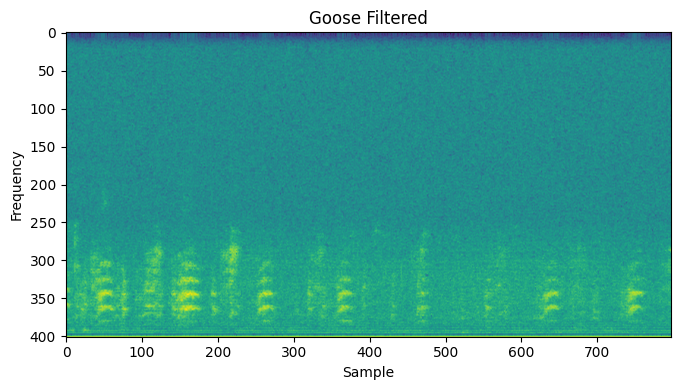

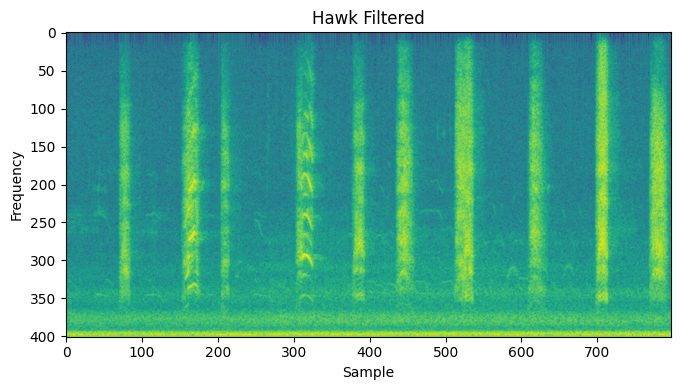

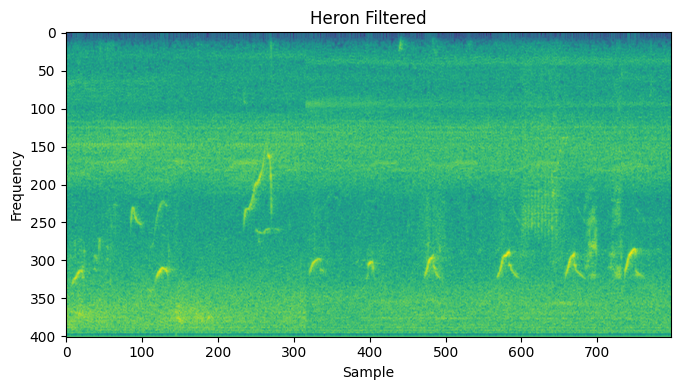

In [210]:
plot_spectrogram(goose_spectrograms[24, :, :], 'Goose Filtered')
plot_spectrogram(hawk_spectrograms[19, :, :], 'Hawk Filtered')
plot_spectrogram(heron_spectrograms[27, :, :], 'Heron Filtered')

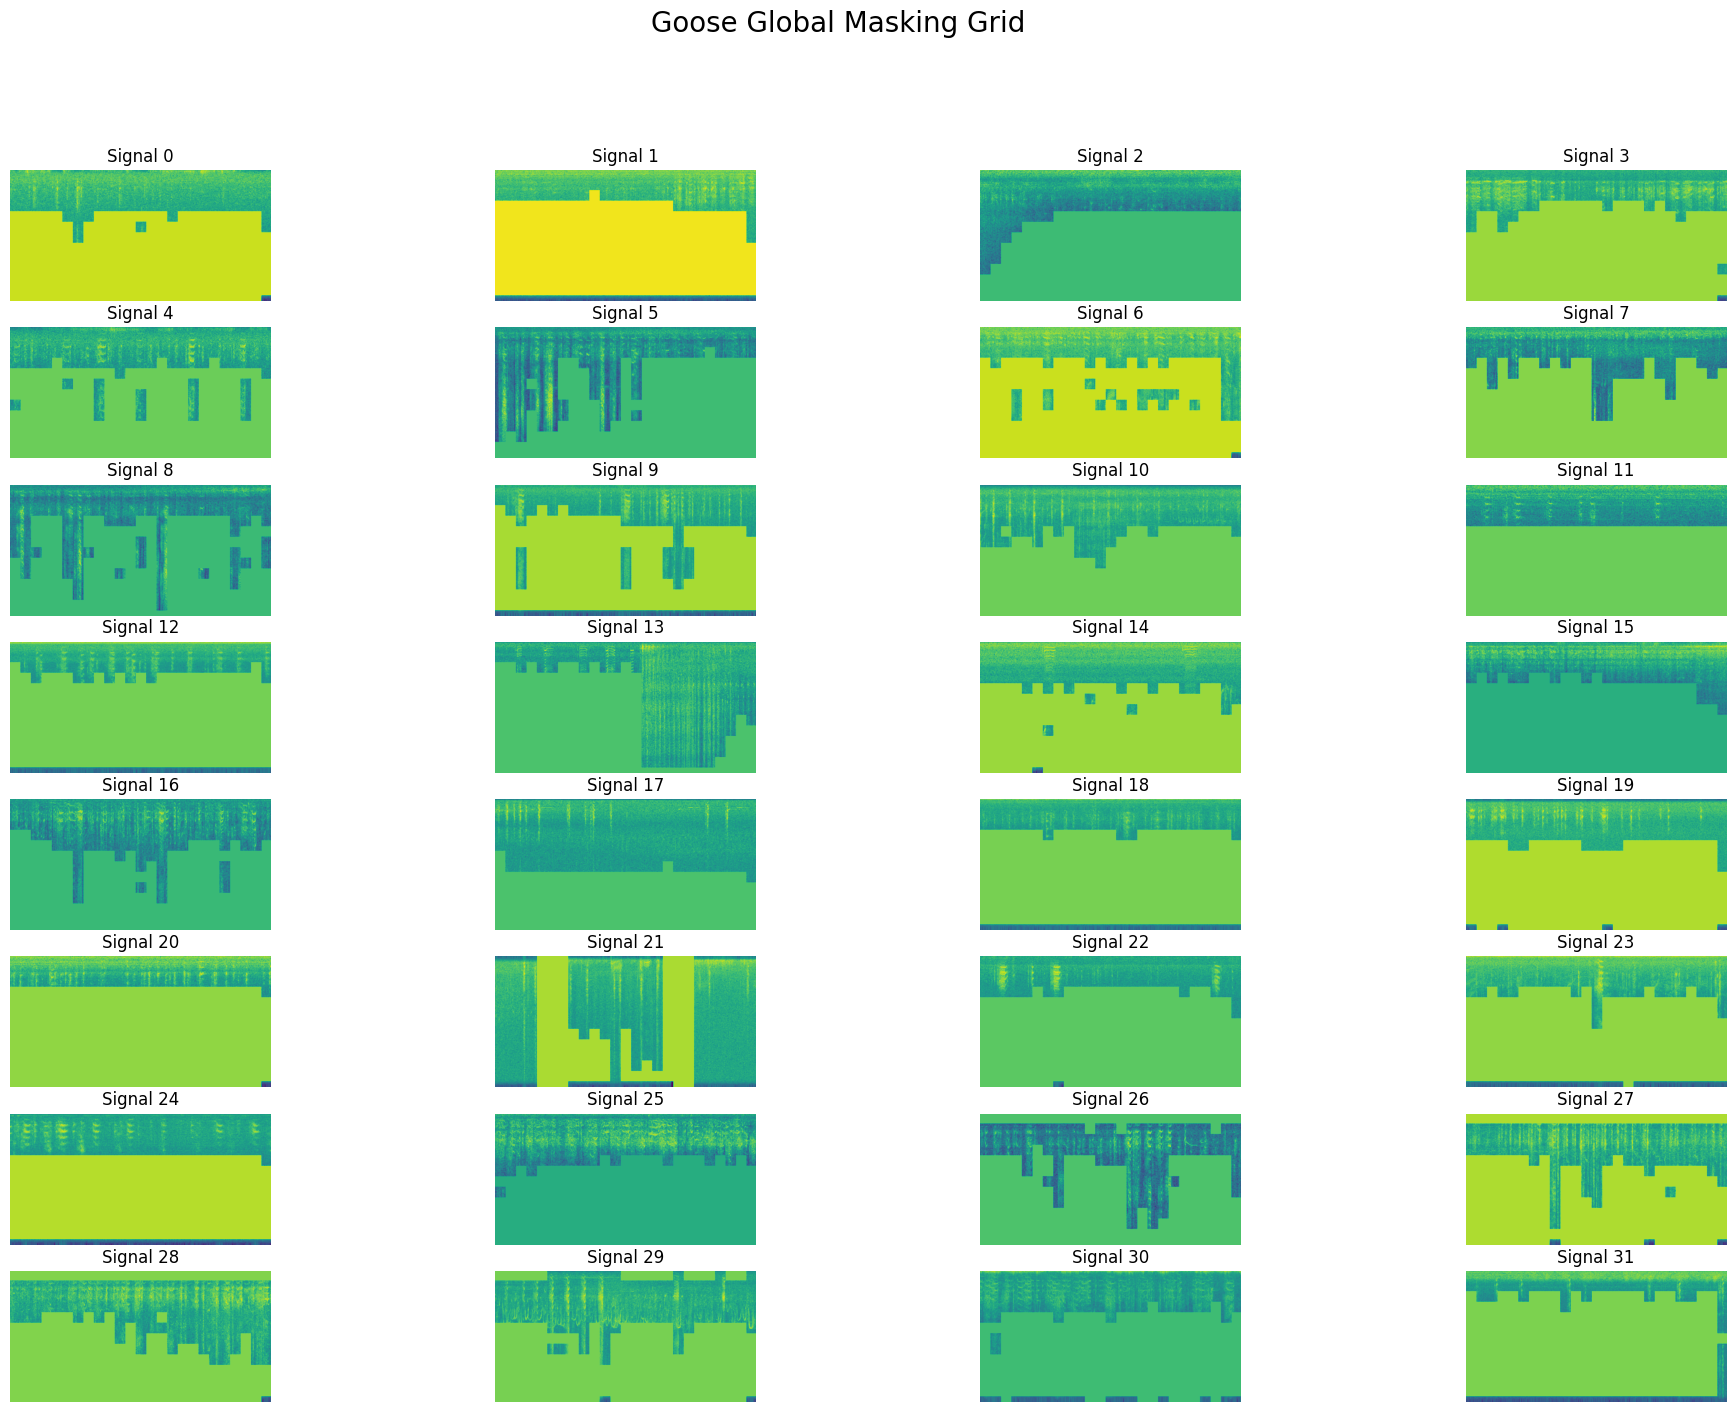

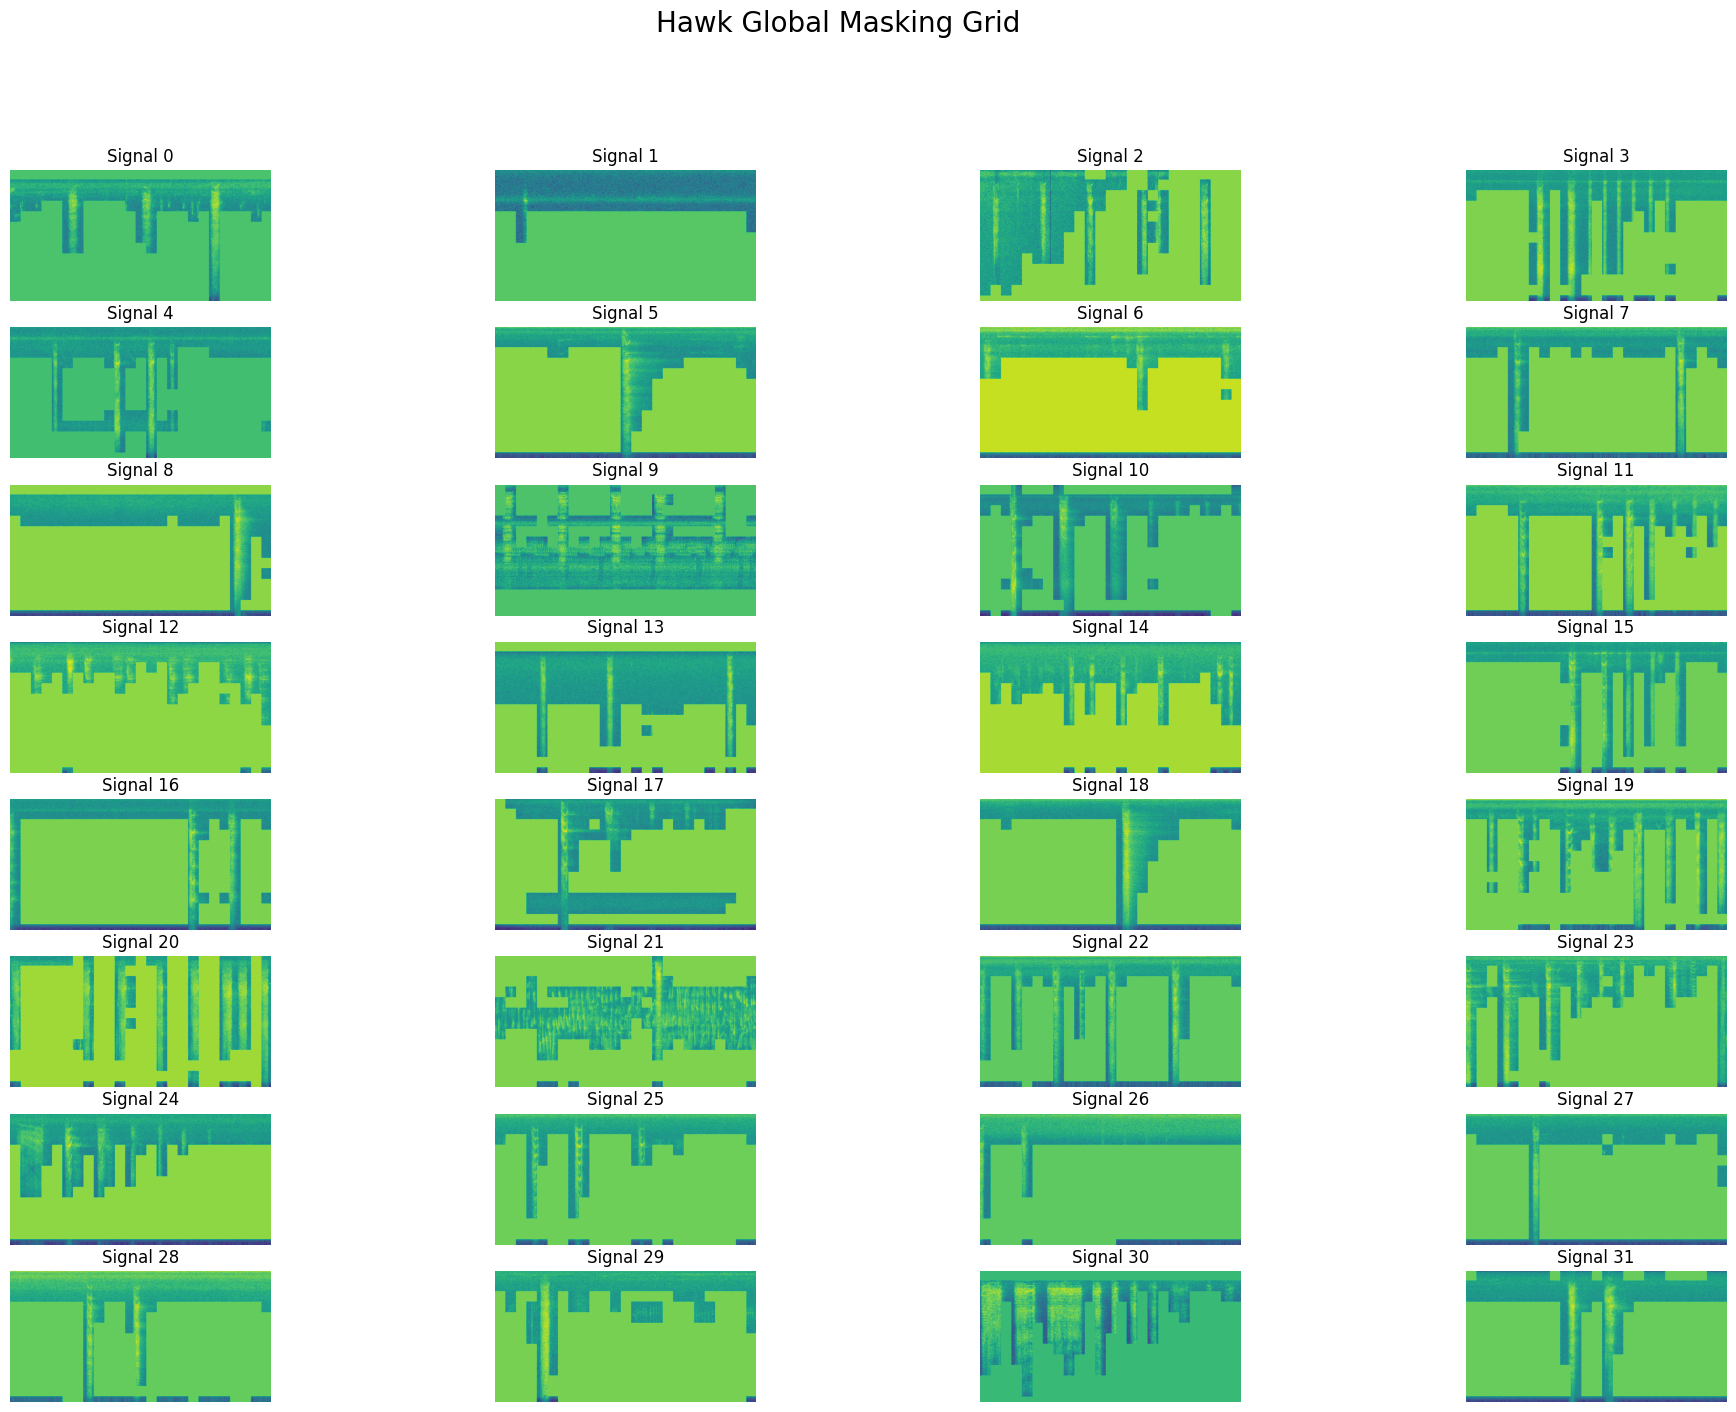

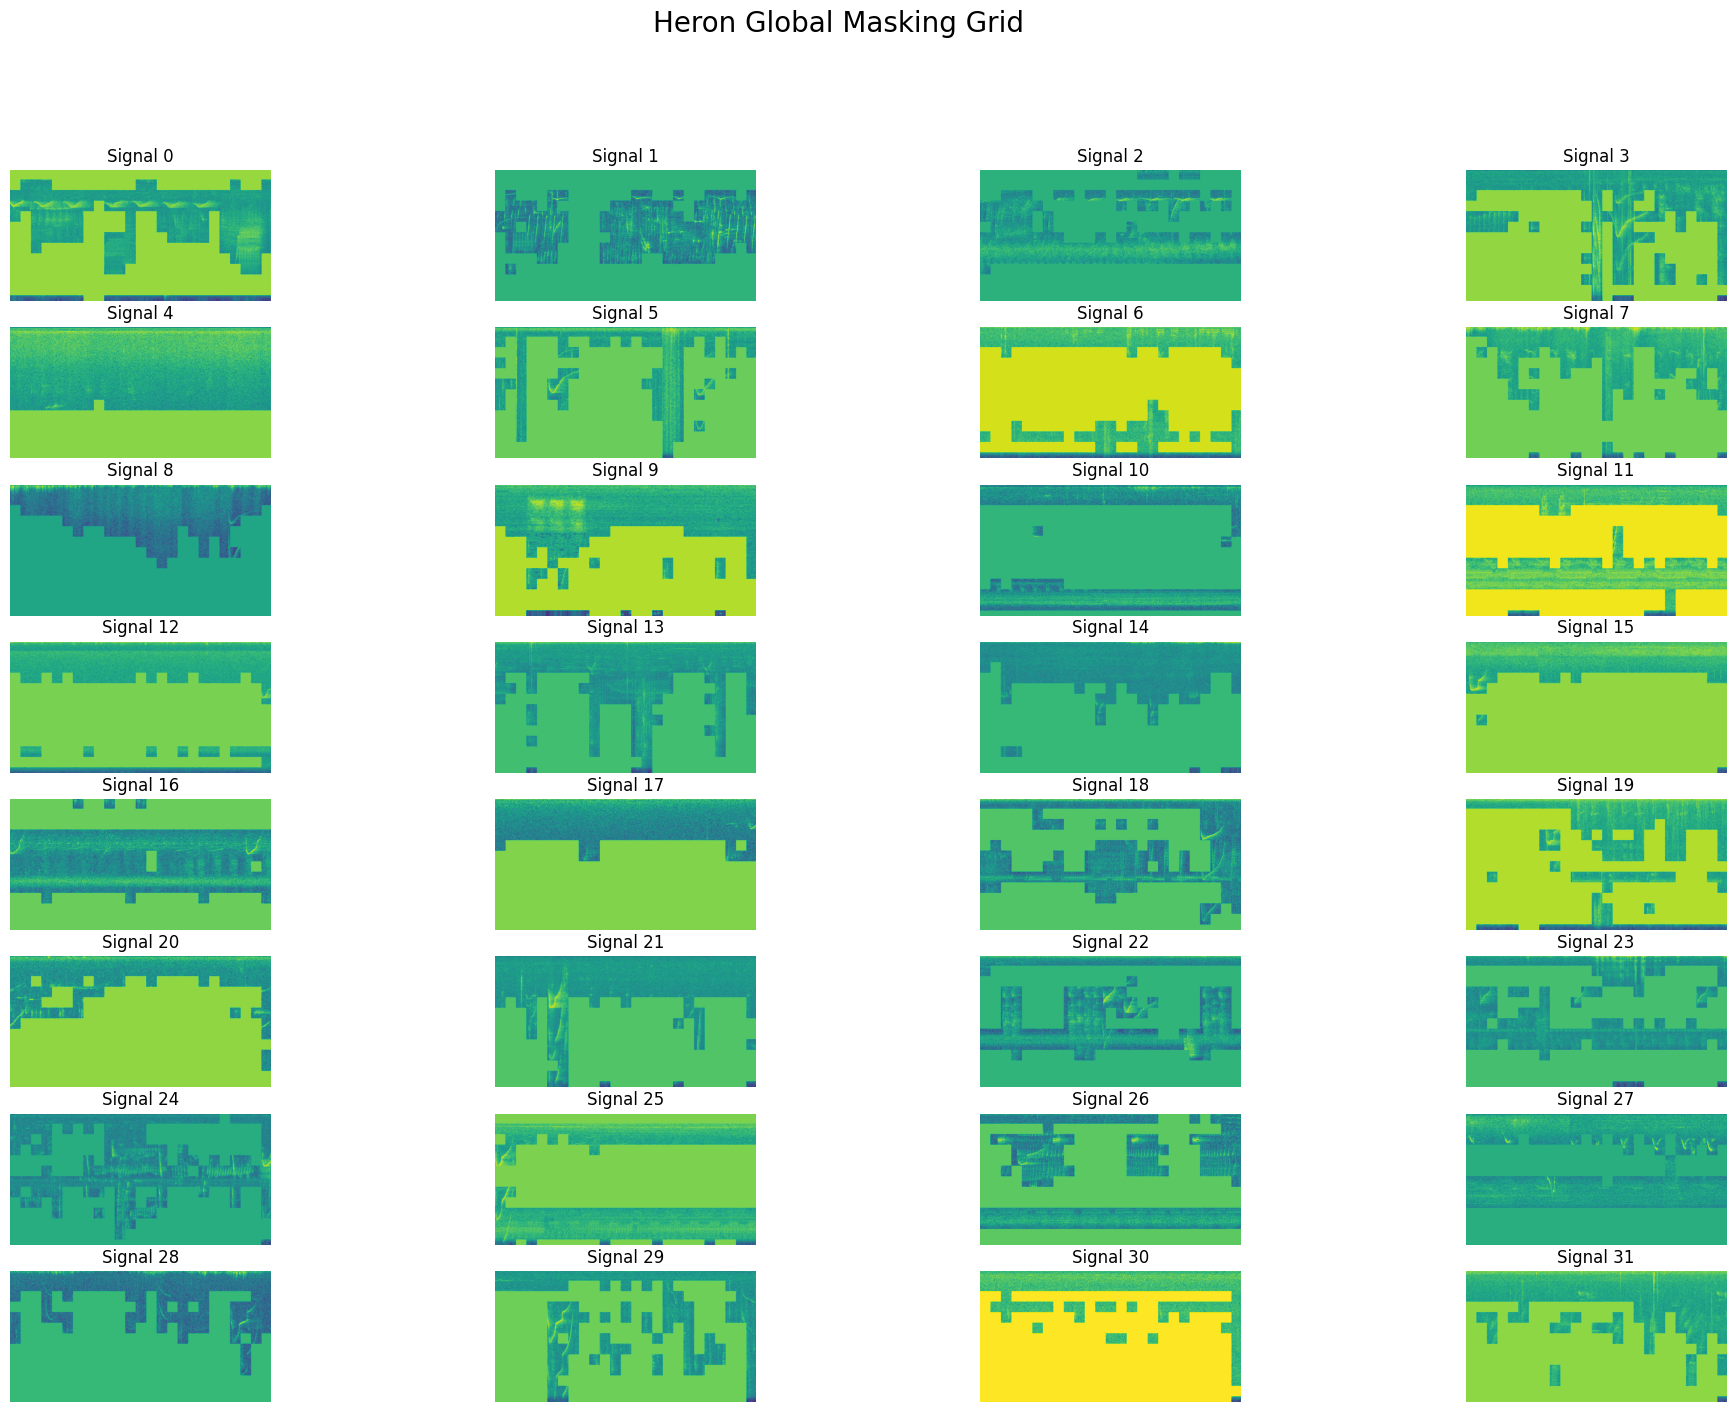

In [193]:
plot_spectrograms(goose_spectrograms, 'Goose Global Masking Grid')
plot_spectrograms(hawk_spectrograms, 'Hawk Global Masking Grid')
plot_spectrograms(heron_spectrograms, 'Heron Global Masking Grid')
